In [222]:
import modal
from egfr_binder_rd2.utils import hash_seq, load_evolution_metadata
from egfr_binder_rd2 import EGFR, EGFS, OFFICIAL_EGFR
import pandas as pd
from pathlib import Path
from egfr_binder_rd2 import MODAL_VOLUME_PATH, OUTPUT_DIRS
from egfr_binder_rd2.fold import get_a3m_path
import seaborn as sns
from egfr_binder_rd2.solubility import calculate_solubility
from egfr_binder_rd2.fitness import get_fitness
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

get_msa = modal.Function.lookup("simplefold", 'get_msa_for_binder')
# a3m_from_template = modal.Function.lookup("simplefold", 'a3m_from_template')
fold_binder = modal.Function.lookup("simplefold", 'fold_binder')
update_metrics = modal.Function.lookup("simplefold", 'update_metrics_for_all_folded')
esm2_pll = modal.Function.lookup("esm2-inference", 'process_sequences')
esm2_pll_exact = modal.Function.lookup("esm2-inference", 'process_sequences_exact')
update_pll_metrics = modal.Function.lookup("esm2-inference", 'update_pll_metrics')
get_exact_plls = modal.Function.lookup("esm2-inference", 'update_exact_pll_metrics')
sample_sequences = modal.Function.lookup("bt-training", 'sample_sequences')
update_high_quality_metrics = modal.Function.lookup("simplefold", 'update_high_quality_metrics')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [223]:
df = get_fitness()

In [9]:
df.dropna(subset=['fitness']).sort_values('fitness', ascending=False).head(40).iloc[0]['binder_sequence']

'NLFSRCPKRYHGICENNGQCRYAINLRTYTCICDSGYTGDRCQELDIRYLLLLN'

In [14]:
df

,seq_hash,binder_length,fitness,pae_interaction,i_ptm,sequence_log_pll,p_soluble,pae_interaction_rank,i_ptm_rank,sequence_log_pll_rank,p_soluble_rank,binder_plddt,binder_hydropathy,binder_pae,ptm,binder_charged_fraction,binder_hydrophobic_fraction,binder_sequence
0,29a580,54,0.831,7.428,0.95,-78.337,0.051,0.993,0.973,0.988,0.368,92.210,0.448,3.258,0.87,0.241,0.315,NLFSRCPKRYHGICENNGQCRYAINLRTYTCICDSGYTGDRCQELD...
1,72da1a,45,0.825,7.964,0.94,-116.637,0.174,0.858,0.881,0.918,0.641,89.974,0.379,3.665,0.86,0.311,0.244,SYDGYCNNHGVCRHIESLDSWTCQCRQGYEGDRCQTRDLRWLELN
2,ed13c2,54,0.821,7.608,0.94,-77.464,0.069,0.966,0.881,0.990,0.448,91.614,0.455,3.187,0.86,0.204,0.315,YTFSECPSKYEGICNNNGVCRYAINLRSNTCICNEGYRGPRCQEID...
3,fdd09c,54,0.818,7.666,0.95,-80.322,0.049,0.953,0.973,0.982,0.363,91.419,0.491,3.459,0.87,0.241,0.333,GLFSKCPSKFHGICNNNGVCRYAINLRSYTCICLEGYTGDRCQELD...
4,0a1062,54,0.817,7.367,0.95,-81.050,0.041,0.998,0.973,0.979,0.316,92.425,0.452,3.195,0.87,0.241,0.315,ELFSRCPKRYHGICGNNGQCRYAINLRTYTCRCVSGYTGDRCQELD...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,b6842f,54,NaN,14.681,0.77,NaN,0.301,0.187,0.140,NaN,0.712,60.362,0.401,9.360,0.74,0.315,0.278,NLFKRHPKRYHGIKENNGQCRYAINMRPATCICDSGYTGDRCQELD...
7557,be61ab,54,NaN,10.861,0.90,NaN,0.262,0.297,0.387,NaN,0.696,77.969,0.415,5.708,0.80,0.296,0.315,ILFSECPKRYNGICENNGQDRYAINLETYTHKCYSGYTGDRCHELD...
7558,d5a888,54,NaN,16.604,0.71,NaN,0.540,0.151,0.122,NaN,0.793,50.529,0.400,11.567,0.72,0.315,0.278,NLFSRKPPEYGGINENNGTVRHAKNLRTYTCDCKDGYTGDRCDELD...
7559,e0cd11,54,NaN,14.850,0.75,NaN,0.428,0.184,0.133,NaN,0.761,59.361,0.404,9.666,0.73,0.296,0.259,NLFSPTPKRYGGINENNCTCRHAKNLRTYTHVCHEGYTGDRCDELD...


In [32]:
hq_results, top_ranked = update_high_quality_metrics.remote()
exact_plls = get_exact_plls.remote()

In [ ]:
edf = df.merge(exact_plls.add_prefix('exact_'), left_on='binder_sequence', right_on='exact_sequence', how='left')
edf['exact_sequence_log_pll_rank'] = edf['exact_sequence_log_pll'].rank(ascending=True, pct=True)
edf['exact_fitness'] = (edf['i_ptm_rank'] + edf['exact_sequence_log_pll_rank'] + edf['pae_interaction_rank']) / 3


In [72]:
edf.sort_values('exact_fitness', ascending=False).head(40)

,seq_hash,binder_length,fitness,pae_interaction,i_ptm,sequence_log_pll,p_soluble,pae_interaction_rank,i_ptm_rank,sequence_log_pll_rank,p_soluble_rank,binder_plddt,binder_hydropathy,binder_pae,ptm,binder_charged_fraction,binder_hydrophobic_fraction,binder_sequence,exact_sequence_hash,exact_sequence,exact_sequence_length,exact_normalized_log_pll,exact_sequence_log_pll,exact_sequence_log_pll_rank,exact_fitness
315,446a03,44,0.744,7.458,0.95,-202.558,0.050,0.990,0.973,0.650,0.364,93.206,0.386,2.647,0.86,0.227,0.227,CPRRYNGICTNNGRCQYARNLRTYTCQCLPGYTKPRCQELDIRY,5b464c,CPRRYNGICTNNGRCQYARNLRTYTCQCLPGYTKPRCQELDIRY,44.0,-2.045404,-89.997771,0.797670,0.920223
538,724304,44,0.724,7.515,0.95,-240.786,0.062,0.982,0.973,0.523,0.420,93.081,0.390,2.660,0.86,0.227,0.227,CPRRYNGICTNNGRCQYARNLHTYTCQCLPGYTKPRCQELDIRY,6c7b37,CPRRYNGICTNNGRCQYARNLHTYTCQCLPGYTKPRCQELDIRY,44.0,-2.115659,-93.088998,0.754192,0.903064
884,fa6545,44,0.696,7.757,0.94,-172.043,0.027,0.930,0.881,0.770,0.202,91.996,0.425,2.823,0.85,0.182,0.250,CPRRYRGICTNNGSCQYAINLRTYTCQCLPGYTGPRCQELDIRY,6e072c,CPRRYRGICTNNGSCQYAINLRTYTCQCLPGYTGPRCQELDIRY,44.0,-1.916364,-84.320013,0.880932,0.897311
2501,b4e033,45,0.585,8.075,0.94,-287.746,0.038,0.814,0.881,0.352,0.294,89.782,0.485,3.748,0.85,0.222,0.356,SYDGYCLNGGVCMHIESLDTYTCNCVIGYSGDRCQTLDLRWLELR,b931d8,SYDGYCLNGGVCMHIESLDTYTCNCVIGYSGDRCQTLDLRWLELR,45.0,-1.641301,-73.858528,0.971867,0.888956
504,c6e7a9,45,0.727,8.105,0.94,-177.916,0.075,0.800,0.881,0.755,0.473,89.824,0.426,3.684,0.85,0.267,0.289,SYDGYCLNRGVCQHIESLDSYTCKCLPGYTGDRCQTQDLRWLELR,ed568a,SYDGYCLNRGVCQHIESLDSYTCKCLPGYTGDRCQTQDLRWLELR,45.0,-1.672269,-75.252092,0.967178,0.882726
126,9fbb66,48,0.770,7.665,0.94,-173.947,0.077,0.953,0.881,0.766,0.478,91.427,0.412,3.217,0.87,0.208,0.229,SNCPRRYRGICENNGTCKYATNLRTYTCQCLSGYTGARCQELDIRYLN,38ac13,SNCPRRYRGICENNGTCKYATNLRTYTCQCLSGYTGARCQELDIRYLN,48.0,-1.852783,-88.933578,0.814152,0.882717
720,1182b7,45,0.708,8.075,0.94,-214.333,0.094,0.814,0.881,0.613,0.526,89.741,0.425,3.704,0.85,0.289,0.289,SYDGYCLNNAVCRHIESLDSYTCVCKQGYTGDRCQTRDLRWLELR,05edef,SYDGYCLNNAVCRHIESLDSYTCVCKQGYTGDRCQTRDLRWLELR,45.0,-1.732217,-77.949767,0.951549,0.882183
21,632ea6,45,0.802,8.071,0.94,-140.281,0.165,0.816,0.881,0.878,0.634,89.731,0.390,3.689,0.85,0.311,0.244,SYDGYCLNRGECQHIHSLDSYTCKCEPGYTGDRCQTQDLRWLELR,295ba0,SYDGYCLNRGECQHIHSLDSYTCKCEPGYTGDRCQTQDLRWLELR,45.0,-1.754903,-78.970628,0.943024,0.880008
6,f5effd,45,0.815,8.020,0.94,-107.506,0.130,0.835,0.881,0.953,0.593,89.567,0.397,3.693,0.86,0.289,0.267,SYEGYCENRGTCQHIESLDSYTCKCLKGYTGDRCQSQDLRYLYLE,c95f67,SYEGYCENRGTCQHIESLDSYTCKCLKGYTGDRCQSQDLRYLYLE,45.0,-1.820030,-81.901372,0.911481,0.875827
1408,679a56,46,0.657,8.145,0.94,-250.044,0.079,0.780,0.881,0.483,0.485,88.534,0.421,4.039,0.86,0.283,0.283,SYDGYCLNGGVCKHIESLDSYTCQCRIGYSGDRCQTRDLRWLELRN,c28a2e,SYDGYCLNGGVCKHIESLDSYTCQCRIGYSGDRCQTRDLRWLELRN,46.0,-1.665718,-76.623012,0.960926,0.873975


In [ ]:

edf.sort_values('exact_fitness', ascending=False).head(40)['binder_sequence'].to_list()

In [73]:
cols = [
    'seq_hash', 'binder_length','pae_interaction', 'i_ptm', 'exact_sequence_log_pll','pae_interaction_rank', 'i_ptm_rank', 'exact_sequence_log_pll_rank', 'exact_fitness',
    'p_soluble', 'p_soluble_rank', 'binder_plddt', 'binder_hydropathy',  'binder_charged_fraction',
       'binder_hydrophobic_fraction', 'binder_sequence', 
]

In [79]:
edf = edf[edf['binder_sequence'].isin(exact['binder_sequence'])]

In [88]:
edf.query('i_ptm > 0.9').query('p_soluble > 0.1')['binder_sequence'].to_list()

['SYDGKCLNNGKCRYIEDLDSYTCQCESGYTGDRCQTRDLRWLELH',
 'SYEGYCENRGTCQHIESLDSYTCKCLKGYTGDRCQSQDLRYLYLE',
 'KYDGYCNNHGECQHIHSLDSYTCKCLPGYEGDRCQTQDLRWLELR',
 'SYDGYCNNRGVCRHIESLDSYTCKCDQGYEGDRCQTRDLRWLELH',
 'SYNGYCKNGGQCQHIISLDQYTCRCESGYEGDRCQTRDLRWLELR',
 'SYDGYCLNRGECQHIHSLDSYTCKCEPGYTGDRCQTQDLRWLELR',
 'SYDGYCNNRGVCRHIESLDTYTCQCKQGYEGDRCETRDLRWLELY',
 'TYDGYCLNGGKCEHVESLDKYTCNCVSGYTGDRCQERDLRWLEHQ']

In [89]:
edf.query('i_ptm > 0.88').sort_values('exact_fitness', ascending=False)[cols].head(50)

,seq_hash,binder_length,pae_interaction,i_ptm,exact_sequence_log_pll,pae_interaction_rank,i_ptm_rank,exact_sequence_log_pll_rank,exact_fitness,p_soluble,p_soluble_rank,binder_plddt,binder_hydropathy,binder_charged_fraction,binder_hydrophobic_fraction,binder_sequence
315,446a03,44,7.458,0.95,-89.997771,0.990,0.973,0.797670,0.920223,0.050,0.364,93.206,0.386,0.227,0.227,CPRRYNGICTNNGRCQYARNLRTYTCQCLPGYTKPRCQELDIRY
538,724304,44,7.515,0.95,-93.088998,0.982,0.973,0.754192,0.903064,0.062,0.420,93.081,0.390,0.227,0.227,CPRRYNGICTNNGRCQYARNLHTYTCQCLPGYTKPRCQELDIRY
884,fa6545,44,7.757,0.94,-84.320013,0.930,0.881,0.880932,0.897311,0.027,0.202,91.996,0.425,0.182,0.250,CPRRYRGICTNNGSCQYAINLRTYTCQCLPGYTGPRCQELDIRY
2501,b4e033,45,8.075,0.94,-73.858528,0.814,0.881,0.971867,0.888956,0.038,0.294,89.782,0.485,0.222,0.356,SYDGYCLNGGVCMHIESLDTYTCNCVIGYSGDRCQTLDLRWLELR
504,c6e7a9,45,8.105,0.94,-75.252092,0.800,0.881,0.967178,0.882726,0.075,0.473,89.824,0.426,0.267,0.289,SYDGYCLNRGVCQHIESLDSYTCKCLPGYTGDRCQTQDLRWLELR
126,9fbb66,48,7.665,0.94,-88.933578,0.953,0.881,0.814152,0.882717,0.077,0.478,91.427,0.412,0.208,0.229,SNCPRRYRGICENNGTCKYATNLRTYTCQCLSGYTGARCQELDIRYLN
720,1182b7,45,8.075,0.94,-77.949767,0.814,0.881,0.951549,0.882183,0.094,0.526,89.741,0.425,0.289,0.289,SYDGYCLNNAVCRHIESLDSYTCVCKQGYTGDRCQTRDLRWLELR
21,632ea6,45,8.071,0.94,-78.970628,0.816,0.881,0.943024,0.880008,0.165,0.634,89.731,0.390,0.311,0.244,SYDGYCLNRGECQHIHSLDSYTCKCEPGYTGDRCQTQDLRWLELR
6,f5effd,45,8.020,0.94,-81.901372,0.835,0.881,0.911481,0.875827,0.130,0.593,89.567,0.397,0.289,0.267,SYEGYCENRGTCQHIESLDSYTCKCLKGYTGDRCQSQDLRYLYLE
1408,679a56,46,8.145,0.94,-76.623012,0.780,0.881,0.960926,0.873975,0.079,0.485,88.534,0.421,0.283,0.283,SYDGYCLNGGVCKHIESLDSYTCQCRIGYSGDRCQTRDLRWLELRN


In [22]:
edf.iloc[0]['binder_sequence']

'NLFSRCPKRYHGICENNGQCRYAINLRTYTCICDSGYTGDRCQELDIRYLLLLN'

In [18]:
edf.query('i_ptm > 0.93').sort_values('exact_sequence_log_pll', ascending=False).head(40)

,seq_hash,binder_length,fitness,pae_interaction,i_ptm,sequence_log_pll,p_soluble,pae_interaction_rank,i_ptm_rank,sequence_log_pll_rank,p_soluble_rank,binder_plddt,binder_hydropathy,binder_pae,ptm,binder_charged_fraction,binder_hydrophobic_fraction,binder_sequence,exact_sequence_hash,exact_sequence,exact_sequence_length,exact_normalized_log_pll,exact_sequence_log_pll,exact_sequence_log_pll_rank,exact_fitness
2501,b4e033,45,0.585,8.075,0.94,-287.746,0.038,0.814,0.881,0.352,0.294,89.782,0.485,3.748,0.85,0.222,0.356,SYDGYCLNGGVCMHIESLDTYTCNCVIGYSGDRCQTLDLRWLELR,b931d8,SYDGYCLNGGVCMHIESLDTYTCNCVIGYSGDRCQTLDLRWLELR,45.0,-1.641301,-73.858528,0.971867,0.888956
504,c6e7a9,45,0.727,8.105,0.94,-177.916,0.075,0.800,0.881,0.755,0.473,89.824,0.426,3.684,0.85,0.267,0.289,SYDGYCLNRGVCQHIESLDSYTCKCLPGYTGDRCQTQDLRWLELR,ed568a,SYDGYCLNRGVCQHIESLDSYTCKCLPGYTGDRCQTQDLRWLELR,45.0,-1.672269,-75.252092,0.967178,0.882726
1408,679a56,46,0.657,8.145,0.94,-250.044,0.079,0.780,0.881,0.483,0.485,88.534,0.421,4.039,0.86,0.283,0.283,SYDGYCLNGGVCKHIESLDSYTCQCRIGYSGDRCQTRDLRWLELRN,c28a2e,SYDGYCLNGGVCKHIESLDSYTCQCRIGYSGDRCQTRDLRWLELRN,46.0,-1.665718,-76.623012,0.960926,0.873975
720,1182b7,45,0.708,8.075,0.94,-214.333,0.094,0.814,0.881,0.613,0.526,89.741,0.425,3.704,0.85,0.289,0.289,SYDGYCLNNAVCRHIESLDSYTCVCKQGYTGDRCQTRDLRWLELR,05edef,SYDGYCLNNAVCRHIESLDSYTCVCKQGYTGDRCQTRDLRWLELR,45.0,-1.732217,-77.949767,0.951549,0.882183
21,632ea6,45,0.802,8.071,0.94,-140.281,0.165,0.816,0.881,0.878,0.634,89.731,0.390,3.689,0.85,0.311,0.244,SYDGYCLNRGECQHIHSLDSYTCKCEPGYTGDRCQTQDLRWLELR,295ba0,SYDGYCLNRGECQHIHSLDSYTCKCEPGYTGDRCQTQDLRWLELR,45.0,-1.754903,-78.970628,0.943024,0.880008
1979,5f5378,46,0.618,8.088,0.94,-253.297,0.042,0.809,0.881,0.462,0.321,88.820,0.436,3.840,0.86,0.261,0.304,SYDGYCLNGGVCHRIESLHSYTCQCRIGYSGDRCQTRDLRWLELQM,f091b9,SYDGYCLNGGVCHRIESLHSYTCQCRIGYSGDRCQTRDLRWLELQM,46.0,-1.778806,-81.825057,0.912617,0.867539
6,f5effd,45,0.815,8.020,0.94,-107.506,0.130,0.835,0.881,0.953,0.593,89.567,0.397,3.693,0.86,0.289,0.267,SYEGYCENRGTCQHIESLDSYTCKCLKGYTGDRCQSQDLRYLYLE,c95f67,SYEGYCENRGTCQHIESLDSYTCKCLKGYTGDRCQSQDLRYLYLE,45.0,-1.820030,-81.901372,0.911481,0.875827
763,db94ed,46,0.705,8.251,0.94,-177.243,0.072,0.721,0.881,0.758,0.460,88.503,0.410,4.057,0.86,0.261,0.261,HYDGYCLNGGACRRIESLDSYTCQCQIGYSGDRCQTRDLRWLELQQ,3011d9,HYDGYCLNGGACRRIESLDSYTCQCQIGYSGDRCQTRDLRWLELQQ,46.0,-1.781809,-81.963199,0.910486,0.837495
345,041fff,46,0.741,8.068,0.94,-174.866,0.085,0.817,0.881,0.765,0.502,88.927,0.396,3.980,0.86,0.283,0.239,HYDGYCLNGGACRRIESLDSYTCQCQRGYSGDRCQTRDLRWLELQG,cefb53,HYDGYCLNGGACRRIESLDSYTCQCQRGYSGDRCQTRDLRWLELQG,46.0,-1.794618,-82.552436,0.903950,0.867317
1874,e27f5f,46,0.624,8.091,0.94,-254.263,0.047,0.808,0.881,0.456,0.351,88.589,0.436,3.913,0.86,0.261,0.304,TYDGYCLNGGVCHRIESLHSYTCQCRIGYSGDRCQTRDLRWLELQM,7073d5,TYDGYCLNGGVCHRIESLHSYTCQCRIGYSGDRCQTRDLRWLELQM,46.0,-1.794790,-82.560326,0.903808,0.864269


In [60]:
exact = top_ranked.merge(exact_plls, left_on='binder_sequence', right_on='sequence', how='left')

In [144]:
exact.sort_values('pae_interaction').head(40).iloc[0]['binder_sequence']

'SLFSKCPRRYHGICGNNGLCRYAINLRTYTCRCVSGYTGYRCQELDIPYLLRLN'

In [62]:
exact['p_soluble'] = exact['binder_sequence'].apply(calculate_solubility)
exact['p_soluble_rank'] = exact['p_soluble'].rank(ascending=True, pct=True)

In [63]:
cols = [
    'seq_hash', 'binder_length','pae_interaction', 'i_ptm', 'sequence_log_pll','pae_interaction_rank', 'i_ptm_rank', 
    'sequence_log_pll_rank',
      'exact_fitness',
    'p_soluble', 'p_soluble_rank', 
    # 'binder_plddt',
      'binder_hydropathy', 
      #   'binder_charged_fraction',
      #  'binder_hydrophobic_fraction', 
       'binder_sequence', 
]

In [65]:
exact['i_ptm_rank'] = exact['i_ptm'].rank(ascending=True, pct=True)
exact['sequence_log_pll_rank'] = exact['sequence_log_pll'].rank(ascending=True, pct=True)
exact['pae_interaction_rank'] = exact['pae_interaction'].rank(ascending=True, pct=True)
exact['exact_fitness'] = (exact['i_ptm_rank'] + exact['sequence_log_pll_rank'] + exact['pae_interaction_rank']) / 3
exact.sort_values('exact_fitness', ascending=False)[cols]

,seq_hash,binder_length,pae_interaction,i_ptm,sequence_log_pll,pae_interaction_rank,i_ptm_rank,sequence_log_pll_rank,exact_fitness,p_soluble,p_soluble_rank,binder_hydropathy,binder_sequence
55,6989fe,45,8.412649,0.94,-75.252092,0.842520,0.259843,0.992126,0.698163,0.075250,0.874016,0.426173,SYDGYCLNRGVCQHIESLDSYTCKCLPGYTGDRCQTQDLRWLELR
59,6b74fb,45,8.395207,0.94,-73.858528,0.818898,0.259843,1.000000,0.692913,0.038276,0.700787,0.484691,SYDGYCLNGGVCMHIESLDTYTCNCVIGYSGDRCQTLDLRWLELR
100,d5bf5a,46,8.466305,0.94,-83.260523,0.881890,0.259843,0.905512,0.682415,0.059004,0.834646,0.399275,SYDGYCLNGGECRRIKSLHSYTCQCRIGYSGDRCQTRDLRYLELQQ
34,48cbe6,45,8.403096,0.94,-78.970628,0.826772,0.259843,0.960630,0.682415,0.164687,0.960630,0.389877,SYDGYCLNRGECQHIHSLDSYTCKCEPGYTGDRCQTQDLRWLELR
10,1aeb7e,45,8.392099,0.94,-77.949767,0.811024,0.259843,0.968504,0.679790,0.093913,0.937008,0.425432,SYDGYCLNNAVCRHIESLDSYTCVCKQGYTGDRCQTRDLRWLELR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,2385aa,54,7.890646,0.95,-121.725969,0.141732,0.708661,0.086614,0.312336,0.017715,0.173228,0.470782,GLFSACPYRYHGICKNNGQCRYAISLRSGTCHCKSGYTGYRCQEID...
80,a1dd79,54,8.046913,0.94,-119.256499,0.527559,0.259843,0.141732,0.309711,0.032631,0.629921,0.456584,SLFSRCPRRYHGICENHGGCRYAINLRTYTCRCVSGYTGDRCQELD...
98,c9f2df,54,7.797242,0.95,-117.638874,0.039370,0.708661,0.157480,0.301837,0.027065,0.527559,0.489918,SLFSLCPSKFHGICNNKGVCRYAINLRSYTCHCLEGYTGPRCQEID...
91,bc62fe,54,7.958679,0.94,-114.647734,0.330709,0.259843,0.314961,0.301837,0.022308,0.370079,0.501852,SLFSLCPSKFHGICNNKGVCRYAINLRSYTCICLEGYTGDRCQEID...


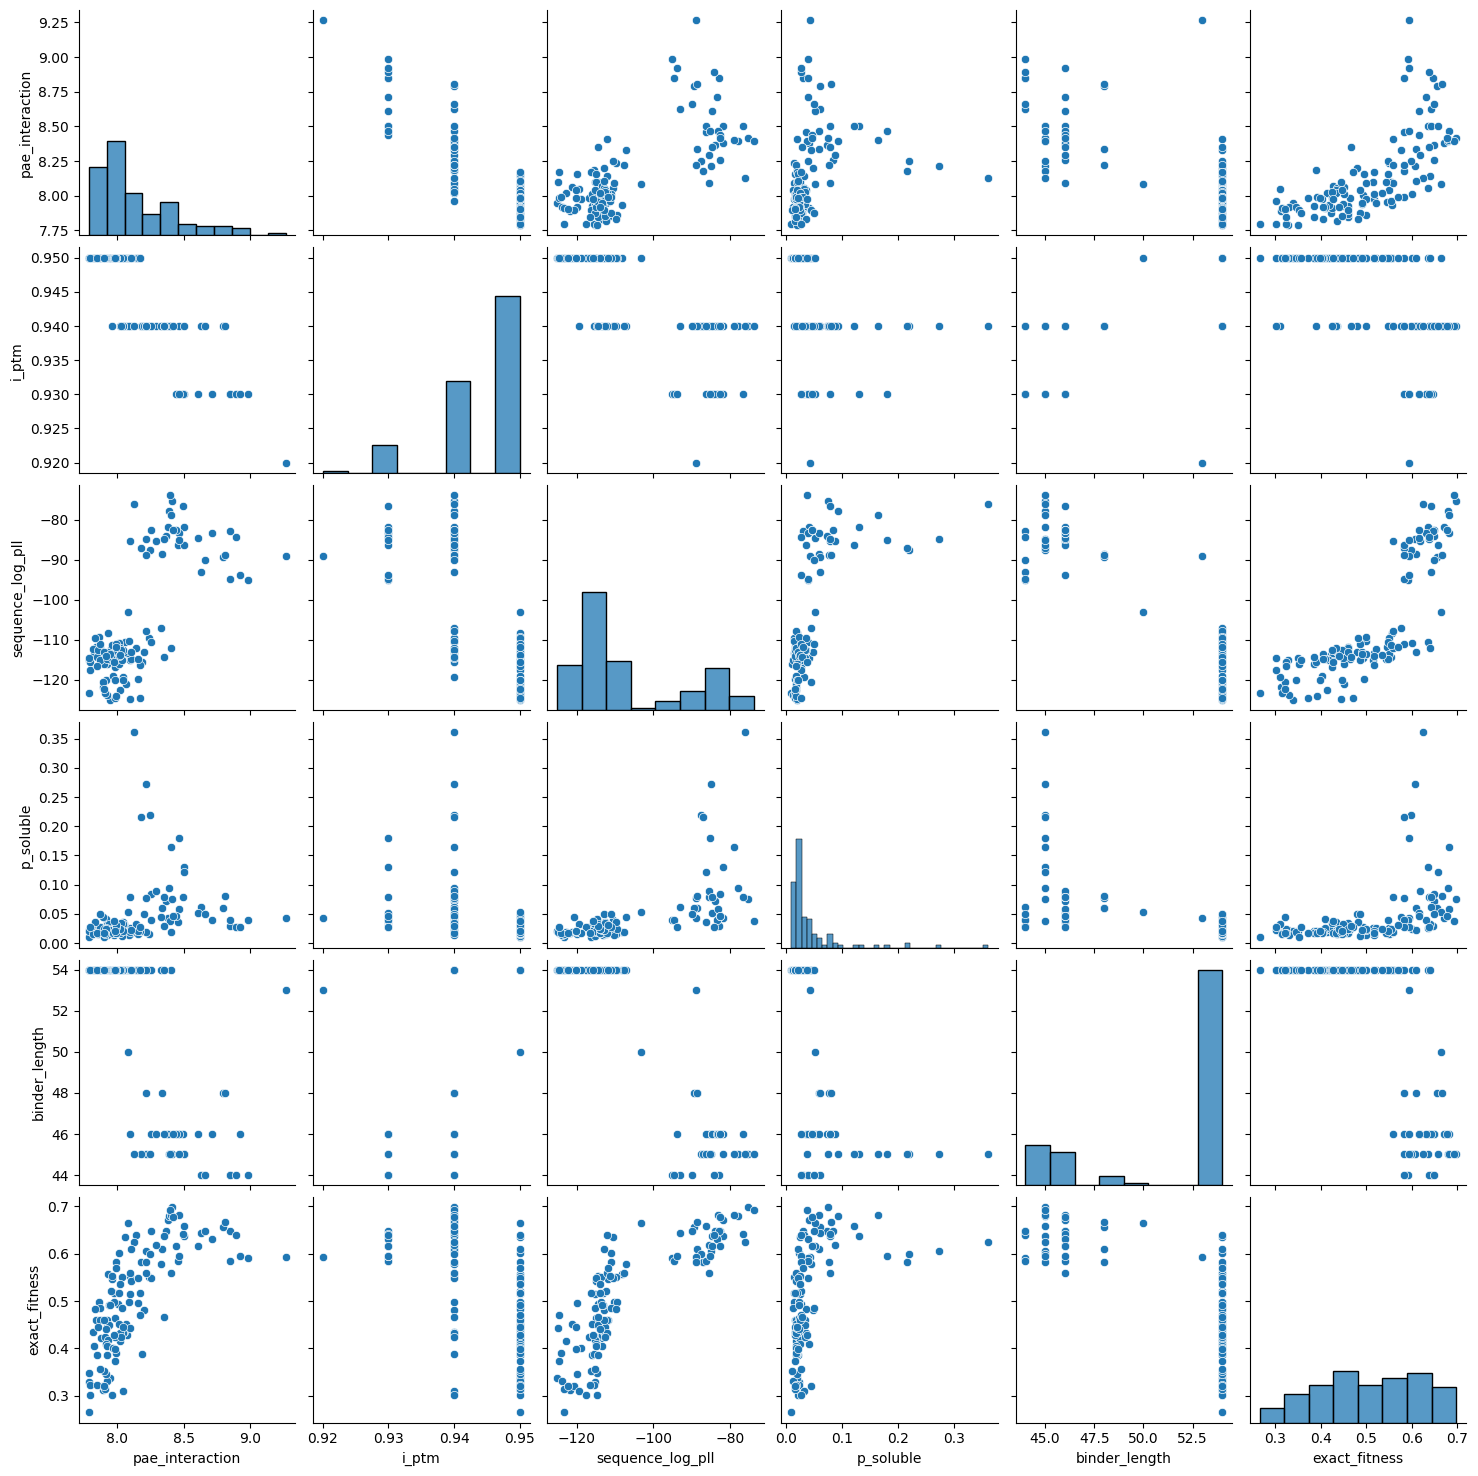

In [70]:
sns.pairplot(exact, vars=['pae_interaction', 'i_ptm', 'sequence_log_pll', 'p_soluble', 'binder_length', 'exact_fitness'])


In [12]:
seq_hash = '72da1a'
f'folded/{seq_hash}_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb'

'folded/72da1a_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb'

<Axes: xlabel='pae_interaction', ylabel='p_soluble'>

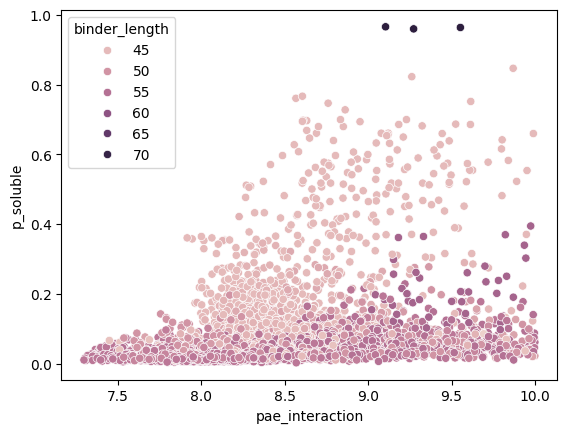

In [9]:
sns.scatterplot(data=df.query('pae_interaction < 10'), x='pae_interaction', y='p_soluble', hue='binder_length')


In [119]:
import torch
from pathlib import Path
from egfr_binder_rd2.bt import PartialEnsembleModule, PartialEnsembleModuleWithFeatures
from egfr_binder_rd2.evoprotgrad import get_expression_model_path
from egfr_binder_rd2 import EGFS

# Set path to models
MODEL_DIR = Path("/home/naka/code/egfr_binder_rd2/data/models")

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load each model directly
models = {}

# Load PAE model
pae_path = MODEL_DIR / "ensemble_pae_interaction_standardize_20241102_235042.pt"
models['pae'] = PartialEnsembleModule.load_model(pae_path).to(device)

# Load iPTM model
iptm_path = MODEL_DIR / "ensemble_i_ptm_standardize_20241102_235512.pt"
models['iptm'] = PartialEnsembleModule.load_model(iptm_path).to(device)

# Load solubility model
soluble_path = MODEL_DIR / "ensemble_p_soluble_standardize_20241104_064636.pt"
models['p_soluble'] = PartialEnsembleModule.load_model(soluble_path).to(device)

# Load PLL model
pll_path = MODEL_DIR / "ensemble_sequence_log_pll_standardize_20241103_215023.pt"
models['pll'] = PartialEnsembleModule.load_model(pll_path).to(device)

model = PartialEnsembleModuleWithFeatures.load_model('/home/naka/code/egfr_binder_rd2/notebooks/expression_model.pt')
model.to(device)
model.eval()
models['expression'] = model

# Put all models in eval mode
for model in models.values():
    model.eval()


/home/naka/code/egfr_binder_rd2/src/egfr_binder_rd2/bt.py:547: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_dict = torch.load(load_path)
/home/naka/code/egfr_binder_r

Model loaded from: /home/naka/code/egfr_binder_rd2/data/models/ensemble_pae_interaction_standardize_20241102_235042.pt
Loaded adapter state dict keys: ['base_model.model.encoder.layer.0.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.query.lora_B.weight', 'base_model.model.encoder.layer.0.attention.self.key.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.key.lora_B.weight', 'base_model.model.encoder.layer.0.attention.self.value.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.value.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.query.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.key.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.key.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.value.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.value.lora_B.weight', 'bas

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from: /home/naka/code/egfr_binder_rd2/data/models/ensemble_i_ptm_standardize_20241102_235512.pt
Loaded adapter state dict keys: ['base_model.model.encoder.layer.0.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.query.lora_B.weight', 'base_model.model.encoder.layer.0.attention.self.key.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.key.lora_B.weight', 'base_model.model.encoder.layer.0.attention.self.value.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.value.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.query.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.key.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.key.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.value.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.value.lora_B.weight', 'base_model.mo

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from: /home/naka/code/egfr_binder_rd2/data/models/ensemble_p_soluble_standardize_20241104_064636.pt
Loaded adapter state dict keys: ['base_model.model.encoder.layer.0.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.query.lora_B.weight', 'base_model.model.encoder.layer.0.attention.self.key.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.key.lora_B.weight', 'base_model.model.encoder.layer.0.attention.self.value.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.value.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.query.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.key.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.key.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.value.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.value.lora_B.weight', 'base_mode

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from: /home/naka/code/egfr_binder_rd2/data/models/ensemble_sequence_log_pll_standardize_20241103_215023.pt
Loaded adapter state dict keys: ['base_model.model.encoder.layer.0.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.query.lora_B.weight', 'base_model.model.encoder.layer.0.attention.self.key.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.key.lora_B.weight', 'base_model.model.encoder.layer.0.attention.self.value.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.value.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.query.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.key.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.key.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.value.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.value.lora_B.weight', 'ba

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from: /home/naka/code/egfr_binder_rd2/notebooks/expression_model.pt
Loaded adapter state dict keys: ['base_model.model.encoder.layer.0.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.query.lora_B.weight', 'base_model.model.encoder.layer.0.attention.self.key.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.key.lora_B.weight', 'base_model.model.encoder.layer.0.attention.self.value.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.value.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.query.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.key.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.key.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.value.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.value.lora_B.weight', 'base_model.model.encoder.layer.2.attentio

/home/naka/code/egfr_binder_rd2/src/egfr_binder_rd2/bt.py:684: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_dict = torch.load(load_path)


In [95]:
len(EGFS)

53

In [91]:

# Test inference
test_sequence = 'SYDGYCNNHGVCRHIESLDSWTCQCRQGYEGDRCQTRDLRWLELN'

results = {}
for name, model in models.items():
    with torch.no_grad():
        # Move both model and inputs to the same device
        model = model.to(device)
        batch = model.tokenizer([test_sequence], return_tensors="pt", padding=True)
        # Move input tensors to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(batch)
        results[name] = {
            'mean': outputs['predictions'].cpu().numpy()[0],
            'std': outputs['uncertainties'].cpu().numpy()[0],
            'ucb': outputs['ucb'].cpu().numpy()[0],
            'head_predictions': outputs['head_predictions'].cpu().numpy()[0]
        }

# Print results
print("\nPredictions for test sequence:")
for metric, values in results.items():
    print(f"\n{metric}:")
    print(f"  mean: {float(values['mean']):.3f}")
    print(f"  std: {float(values['std']):.3f}")
    print(f"  ucb: {float(values['ucb']):.3f}")
    print(f"  head predictions:", values['head_predictions'])


Predictions for test sequence:

pae:
  mean: 5.837
  std: 0.324
  ucb: 5.902
  head predictions: [6.2767587 6.144585  5.4476585 5.7958317 5.773402  5.531122  6.0275383
 5.779131  5.372076  6.2216034]

iptm:
  mean: 2.025
  std: 0.379
  ucb: 2.101
  head predictions: [2.1154506 2.1766994 1.9537842 1.7275444 1.4699237 1.4123757 2.4506853
 2.4065042 2.1384485 2.401392 ]

p_soluble:
  mean: 13.098
  std: 0.080
  ucb: 13.098
  head predictions: [13.005188 13.143966 13.144888]

pll:
  mean: 5.280
  std: 0.311
  ucb: 5.342
  head predictions: [5.612408  5.1567426 5.5200024 5.683124  4.94767   5.444966  5.1224227
 4.7116795 5.43521   5.1622415]


/tmp/ipykernel_653919/657502167.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"  mean: {float(values['mean']):.3f}")
/tmp/ipykernel_653919/657502167.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"  std: {float(values['std']):.3f}")
/tmp/ipykernel_653919/657502167.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"  ucb: {float(values['ucb']):.3f}")


In [92]:
values

{'mean': array([5.2796474], dtype=float32),
 'std': array([0.310775], dtype=float32),
 'ucb': array([5.341802], dtype=float32),
 'head_predictions': array([5.612408 , 5.1567426, 5.5200024, 5.683124 , 4.94767  , 5.444966 ,
        5.1224227, 4.7116795, 5.43521  , 5.1622415], dtype=float32)}

In [96]:
from collections import defaultdict


# Initialize collection of results
collected_results = defaultdict(lambda: defaultdict(list))

def predict_sequence(sequence):
    """Run inference on a single sequence and collect results."""
    results = {'sequence': sequence}
    
    for name, model in models.items():
        with torch.no_grad():
            batch = model.tokenizer([sequence], return_tensors="pt", padding=True)
            batch = {k: v.to(device) for k, v in batch.items()}
            
            outputs = model(batch)
            
            # Store mean and std with model name prefix
            results[f'{name}_mean'] = float(outputs['predictions'].cpu().numpy()[0])
            results[f'{name}_std'] = float(outputs['uncertainties'].cpu().numpy()[0])
            
    return results

In [33]:
seq = 'SYDGYCNNHGVCRHIESLDSWTCQCRQGYEGDRCQTRDLRWLELN'
sequences = [seq]
# Run predictions and collect in a list
results_list = []
for seq in sequences:
    results = predict_sequence(seq)
    results_list.append(results)

/tmp/ipykernel_331397/3020666162.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[f'{name}_mean'] = float(outputs['predictions'].cpu().numpy()[0])
/tmp/ipykernel_331397/3020666162.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[f'{name}_std'] = float(outputs['uncertainties'].cpu().numpy()[0])


In [153]:
import torch
from pathlib import Path
from egfr_binder_rd2.bt import PartialEnsembleModule
import pandas as pd
from itertools import product
import string
from tqdm import tqdm
# Constants
AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")  # Standard amino acids

def generate_single_mutants(sequence):
    """Generate all possible single-point mutations of a sequence."""
    mutants = []
    for pos in range(len(sequence)):
        for aa in AMINO_ACIDS:
            if aa != sequence[pos]:  # Skip wild-type residue
                mutant_seq = sequence[:pos] + aa + sequence[pos+1:]
                mutants.append({
                    'sequence': mutant_seq,
                    'mutation': f"{sequence[pos]}{pos+1}{aa}",
                    'position': pos+1,
                    'wt_aa': sequence[pos],
                    'mut_aa': aa
                })
    return mutants

def predict_sequences(sequences, models, device):
    """Run inference on a list of sequences."""
    results_list = []
    
    for seq_data in tqdm(sequences):
        results = {'sequence': seq_data['sequence']}
        results.update({k: v for k, v in seq_data.items() if k != 'sequence'})  # Add mutation info
        
        for name, model in models.items():
            with torch.no_grad():
                batch = model.tokenizer([seq_data['sequence']], return_tensors="pt", padding=True)
                batch = {k: v.to(device) for k, v in batch.items()}
                
                outputs = model(batch)
                
                results[f'{name}_mean'] = float(outputs['predictions'].cpu().numpy()[0])
                results[f'{name}_std'] = float(outputs['uncertainties'].cpu().numpy()[0])
        
        results['fitness'] = results['pae_mean'] + results['iptm_mean'] + results['expression_mean'] + results['pll_mean']
        results_list.append(results)
    
    return pd.DataFrame(results_list)


In [98]:

# Original sequence
wt_sequence = "SYDGYCNNHGVCRHIESLDSWTCQCRQGYEGDRCQTRDLRWLELN"
wt_sequence = EGFS

# Generate all single mutants
print("Generating single mutants...")
mutants = generate_single_mutants(wt_sequence)
print(f"Generated {len(mutants)} single mutants")


# Run predictions
print("Running predictions...")
df = predict_sequences(mutants, models, device)

# Add wild-type sequence
wt_results = predict_sequences([{'sequence': wt_sequence, 'mutation': 'WT'}], models, device)
df = pd.concat([wt_results, df]).reset_index(drop=True)

# Calculate changes relative to wild-type
wt_values = wt_results.iloc[0]
for col in df.columns:
    if col.endswith('_mean'):
        df[f'delta_{col}'] = df[col] - wt_values[col]
df['delta_fitness'] = df['fitness'] - wt_values['fitness']


Generating single mutants...
Generated 1007 single mutants
Running predictions...


  0%|          | 0/1007 [00:00<?, ?it/s]/tmp/ipykernel_653919/880299988.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[f'{name}_mean'] = float(outputs['predictions'].cpu().numpy()[0])
/tmp/ipykernel_653919/880299988.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[f'{name}_std'] = float(outputs['uncertainties'].cpu().numpy()[0])
100%|██████████| 1/1 [00:00<00:00, 67.34it/s]


In [99]:
df.sort_values('delta_fitness', ascending=False)

,sequence,mutation,pae_mean,pae_std,iptm_mean,iptm_std,p_soluble_mean,p_soluble_std,pll_mean,pll_std,fitness,position,wt_aa,mut_aa,delta_pae_mean,delta_iptm_mean,delta_p_soluble_mean,delta_pll_mean,delta_fitness
389,NSYPGCPSSYDGYCLNGGVCKHIESLDSYTCNCVIGYSGDRCQTRD...,M21K,-2.487074,0.279759,1.398186,0.416579,3.162370,0.156534,5.277093,0.290458,7.350576,21.0,M,K,1.336859,0.881554,6.017046,-0.356829,7.878630
384,NSYPGCPSSYDGYCLNGGVCEHIESLDSYTCNCVIGYSGDRCQTRD...,M21E,-4.694046,0.258654,0.491987,0.474425,4.810873,0.192196,5.199718,0.293690,5.808532,21.0,M,E,-0.870113,-0.024646,7.665549,-0.434205,6.336586
973,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRD...,L52E,-4.561267,0.278165,-0.398763,0.493049,3.772390,0.176466,5.907448,0.309899,4.719807,52.0,L,E,-0.737334,-0.915396,6.627066,0.273525,5.247861
650,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVEGYSGDRCQTRD...,I35E,-4.981136,0.264721,-0.439166,0.473447,3.492266,0.174426,6.411815,0.270037,4.483779,35.0,I,E,-1.157203,-0.955798,6.346942,0.777893,5.011833
654,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVKGYSGDRCQTRD...,I35K,-3.037570,0.295770,-0.182450,0.478294,2.136503,0.252345,5.542297,0.315560,4.458780,35.0,I,K,0.786363,-0.699082,4.991179,-0.091626,4.986834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGCRCQTRD...,D40C,-5.180030,0.263047,-2.975937,0.313301,-11.381232,0.668925,2.378607,0.276185,-17.158592,40.0,D,C,-1.356097,-3.492569,-8.526556,-3.255316,-16.630538
683,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIWYSGDRCQTRD...,G36W,-8.243613,0.335689,-5.267210,0.342118,-6.630641,0.476008,2.778290,0.296670,-17.363175,36.0,G,W,-4.419680,-5.783843,-3.775965,-2.855633,-16.835120
857,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRC...,D46C,-7.941197,0.293856,-2.857213,0.335380,-10.852847,0.599914,4.155618,0.320289,-17.495639,46.0,D,C,-4.117264,-3.373845,-7.998171,-1.478304,-16.967585
287,NSYPGCPSSYDGYCLCGGVCMHIESLDSYTCNCVIGYSGDRCQTRD...,N16C,-8.107410,0.317001,0.300366,0.468568,-9.763755,0.526579,-0.964968,0.275717,-18.535767,16.0,N,C,-4.283477,-0.216266,-6.909079,-6.598890,-18.007712


In [121]:
import random 
def generate_indels(sequence, max_indel_size=3):
    """Generate insertions and deletions of varying sizes."""
    indels = []
    
    # Generate deletions
    for pos in range(len(sequence)):
        for size in range(1, min(max_indel_size + 1, len(sequence) - pos + 1)):
            deleted_seq = sequence[:pos] + sequence[pos+size:]
            if len(deleted_seq) >= 20:  # Minimum sequence length check
                indels.append({
                    'sequence': deleted_seq,
                    'mutation': f"del_{pos+1}_{size}aa",
                    'position': pos+1,
                    'type': 'deletion',
                    'size': size,
                    'deleted': sequence[pos:pos+size]
                })
    
    # Generate insertions
    for pos in range(len(sequence) + 1):  # +1 to allow insertion at end
        # Single AA insertions
        for aa in AMINO_ACIDS:
            inserted_seq = sequence[:pos] + aa + sequence[pos:]
            indels.append({
                'sequence': inserted_seq,
                'mutation': f"ins_{pos+1}_{aa}",
                'position': pos+1,
                'type': 'insertion',
                'size': 1,
                'inserted': aa
            })
        
        # For larger insertions, randomly sample amino acid combinations
        # (full enumeration would be too large)
        if max_indel_size > 1:
            for size in range(2, max_indel_size + 1):
                # Sample some random combinations instead of all possible
                n_samples = 20  # Adjust this number as needed
                for _ in range(n_samples):
                    insertion = ''.join(random.choices(AMINO_ACIDS, k=size))
                    inserted_seq = sequence[:pos] + insertion + sequence[pos:]
                    indels.append({
                        'sequence': inserted_seq,
                        'mutation': f"ins_{pos+1}_{insertion}",
                        'position': pos+1,
                        'type': 'insertion',
                        'size': size,
                        'inserted': insertion
                    })
    
    return indels



In [104]:
df.iloc[0]['sequence']

'NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELRXXXXXXXXXXX'

In [165]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Style the dataframe with a diverging colormap
def color_negative_red(data):
    """
    Takes a series and returns a color scale normalized to that column's range
    """
    def _color_value(val, abs_max):
        if pd.isna(val):
            return ''
        
        # Don't apply to non-numeric columns
        if not isinstance(val, (int, float)):
            return ''
            
        # Normalize value to the column's range
        normalized_val = val / abs_max if abs_max != 0 else 0
        
        # Create blue-white-red color scale
        if val < 0:
            # Negative values are red
            intensity = min(-normalized_val, 1.0)
            color = f'background-color: rgba(255,0,0,{intensity})'
        elif val > 0:
            # Positive values are blue 
            intensity = min(normalized_val, 1.0)
            color = f'background-color: rgba(0,0,255,{intensity})'
        else:
            # Zero is white
            color = 'background-color: rgba(0,0,255,0)'
        return color
    
    # Get the absolute maximum value for this column
    abs_max = abs(data).max()
    return [_color_value(v, abs_max) for v in data]

In [221]:
sequences = [
    "SYDGYCNNHGVCRHIESLDSWTCQCRQGYEGDRCQTRDLRWLELN",
    'SKYDGYCNNHGVCRHIESLDSWTCQCRQGYEGDRCQTRDLRWLELN',
    "SKYDGYCNNHGVCRHIESLDSWTCKCRQGYEGDRCQTRDLRWLELN",
    "SKYDGYCNNHGVCRHIESLDSWTCKCRTGYEGDRCQTRDLRWLELN",
    'SYDGYCLNGGVCMHIESLDTYTCNCVIGYSGDRCQTLDLRWLELR',
    'SYDGYCLNGGVCMHIESLDTYTCNCVKGYSGDRCQTLDLRWLELR',
    'SYDGYCLNGGVCMHIESLDTYTCECVKGYSGDRCQTLDLRWLELR',
    'SYDGYCLNGGVCMHIESLDTYTCECVKGYTGDRCQTLDLRWLELR',
    'SYDGYCLNGGVCMHIESLDTYTCECVKGYTGDRCQTLDLRWLEL',
    'EKGHFKECPRRYRGICTNNGSCQYASNLRTYTCQCLSGYTGARCQELDIRY',
    'EKGHKECPRRYRGICTNNGSCQYASNLRTYTCQCLSGYTGARCQELDIRY',
    'EKGHKECPRRYRGICTNNGSCQYASNLRTYTCQCLEGYTGARCQELDIRY',
    'EGHKECPRRYRGICTNNGSCQYASNLRTYTCQCLEGYTGARCQELDIRY',
    'EGHKECPRRYRGICENNGSCQYASNLRTYTCQCLEGYTGARCQELDIRY',
    'EGHKECPRRYRGICENNGSCRYASNLRTYTCQCLEGYTGARCQELDIRY',
    'EGHKECPRRYRGICENNGSCRYASNLDTYTCQCLEGYTGARCQELDIRY',
]

sequences = [ 
    EGFS + 'XXXXXXXXXXX',
    'NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELREXXXXXXXXXX',
    'NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELREEXXXXXXXXX',
    'CPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELR',
    'PSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELR',
    'PSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWWELR',
    'PSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWLELR',
    'PSYDGYCLNGGVCMHIESLDSYTCECVIGYSGDRCQTRDLRWLELR',
    'PSYDGYCLNGGVCMHIESLDKYTCECVIGYSGDRCQTRDLRWLELR',
    'PSYDGYCLNGGVCMHIESLDKYTCECVIGYTGDRCQTRDLRWLELR',
    'PYDGYCLNGGVCMHIESLDKYTCECVIGYTGDRCQTRDLRWLELR',
    'PYDGYCLNGGVCMHIESLDKYTCECVIGYTGDRCQTRDLRWLELRX',
    'KYDGYCLNGGVCMHIESLDKYTCECVIGYTGDRCQTRDLRWLELRX',
    'KYDGYCLNGGVCMHIESLDKYTCECVIGYTGDRCQTRDLRWLERX',
    'KYDGYCLNGGVCMHIESLDKYTCECVEGYTGDRCQTRDLRWLERX',
    'KYDGYCLNGGVCMHIESLDKYTCECVEGYTGDRCQTRDLRWXXLELR',
    ]
sequences = [
    'DSECPLSHDGYCLHDGVCMYIEALDKYACNCVVGYIGERCQYRDLKWWENLEERLKEHRAKRLALLGPGPPGVVEKEKYKVSITEKVNPGGPATMPMTLTDSNGNKTTLTITVTPEGLEAIRKRRAGEKVKYTMTSTDTGDKFVLVDLDGYCLHDGVCMYIEALDKYACNCVVGYIGERCQYRDLK',
    'CPSHDGYCLHDGVCMYIEALDKYACNCVVGYIGERCQYRDLKWWENLEERLKEHRAKRLALLGPGPPGVVEKEKYKVSITEKVNPGGPATMPMTLTDSNGNKTTLTITVTPEGLEAIRKRRAGEKVKYTMTSTDTGDKFVLVDLDGYCLHDGVCMYIEALDKYACNCVVGYIGERCQYRDLK',
    'CPYSHDGYCLHDGVCMYIEALDKYACNCVVGYIGERCQYRDLKWWENLEERLKEHRAKRLALLGPGPPGVVEKEKYKVSITEKVNPGGPATMPMTLTDSNGNKTTLTITVTPEGLEAIRKRRAGEKVKYTMTSTDTGDKFVLVDLDGYCLHDGVCMYIEALDKYACNCVVGYIGERCQYRDLK',
    'CPYSHDGYCLHDGVCMYIEALDKYACNCVVGYIGERCQYRDLKWWENLEERLKEHRAKRLALLGPGPPGVVEKEKYKVSITEKVNPGGPATMPMTLTDSNGNKTTLTITVTPEGLEAIRKRRAGEKVKYTMTSTDTGDKCVLVDLDGYCLHDGVCMYIEALDKYACNCVVGYIGERCQYRDLK',
]
sequences = [
    'GYKGYCLNQGKCEHVESLDSYTCNCVSGYTGDRCQERDLRWLELR',
    'GYKGYCLNQGKCEHVESLDSYTCKCVSGYTGDRCQERDLRWLELR',
    'GYKGYCLNEGKCEHVESLDSYTCKCVSGYTGDRCQERDLRWLELR',
    'GYKGYCLNEGKCEHVESLDSYTCKCVSGYTGDRCQERDLRWLEL',
    'AYKGYCLNEGKCEHVESLDSYTCKCVSGYTGDRCQERDLRWLEL',
    'AYKGYCLNEGKCEHVESLDSYTCKCVSGYTGDRCQERDLRWLELL',
    'SYDGYCLNRGECQHIHSLDSYTCKCEPGYTGDRCQTQDLRWLELR',
    'SYDGYCLNEGECQHIHSLDSYTCKCEPGYTGDRCQTQDLRWLELR',
    'SYDGYCLNEGECQHIHSLDSYTCKCEPGYTGDRCQTQDLRWLELL',
    'SYDGYCLNEGECRHIHSLDSYTCKCEPGYTGDRCQTQDLRWLELL',
    'SYEGYCLNEGECRHIHSLDSYTCKCEPGYTGDRCQTQDLRWLELL',
    'SYEGYCLNEGECRHIHSLDSYTCKCEPGYTGDRCQTRDLRWLELL',
    'SYEGYCLNEGECRHIHSLDSYTCKCEAGYTGDRCQTRDLRWLELL',
    'SYEGYCLNEGECRHVHSLDSYTCKCEAGYTGDRCQTRDLRWLELL',
    'SYEGYCLNEGECRHVKSLDSYTCKCEAGYTGDRCQTRDLRWLELL',
    'SYEGYCLNGGECRHVKSLDSYTCKCEAGYTGDRCQTRDLRWLELL',
    'SYEGYCLNGGECRHVKSLDTYTCKCEAGYTGDRCQTRDLRWLELL',
    'SYEGYCLNGGECRHVKSLDTYTCKCEAGYTGDRCQTRDLRYLELL',
]

sequences = [
    'NLFSRCPKRYHGICENNGQCRYAINLRTYTCICDSGYTGDRCQELDIRYLLLLN',
    'NLFSRCPKRYAGICENNGQCRYAINLRTYTCICDSGYTGDRCQELDIRYLLLLN',
    'NLFSRCPKRYAGICENNGQCRYAINLRTYTCICKSGYTGDRCQELDIRYLLLLN',
    'NLFSRCPKRYAGICENNGKCRYAINLRTYTCICKSGYTGDRCQELDIRYLLLLN',
]
sequences = [
    'SYEGYCENGGTLVHVESLDSYTCGCLKGYTGDRCQSQDLRYLYLE',
    'SYEGYCENGGTLVHVESLDSYTCKCLKGYTGDRCQSQDLRYLYLE',
    'SYEGYCENGGTCVHVESLDSYTCKCLKGYTGDRCQSQDLRYLYLE',
    'SYEGYCENGGTCVHVESLDSYTCKCLKGYTGDRCQSQDLRYLLLE',
    'SYEGYCENGGTCVHVEALDSYTCKCLKGYTGDRCQSQDLRYLLLE',
]
sequences = [
    'RLFSRCPRRYHGICKNNGQCRYAINLRTYTCRCLSGYTGDRCEELDIRYLLLLY',
    'RLFSRCPRRYHGICKNNGQCKYAINLRTYTCRCLSGYTGDRCEELDIRYLLLLY',
    'RLFSKCPRRYHGICKNNGQCKYAINLRTYTCRCLSGYTGDRCEELDIRYLLLLY',
    'RLFSKCPRRYHGICKNNGTCKYAINLRTYTCRCLSGYTGDRCEELDIRYLLLLY',
    'RLFSKCPRRYEGICKNNGTCKYAINLRTYTCRCLSGYTGDRCEELDIRYLLLLY',
]
'NLFSKCPRRYRGICKNNGKCRYAINLRTYTCICVSGYTGARCQELDIRYLLLRY',
sequences = [
    'CPARYNGICTNHGRCQYARNLRTYTCQCLPGYTKHRCQELDIRY',
    'CPARYNGICTNHGRCQYARNLRTYTCQCLPGYTDHRCQELDIRY',
    'CPARYNGICTNEGRCQYARNLRTYTCQCLPGYTDHRCQELDIRY',
    'CPARYNGICTNEGRCQYARNLETYTCQCLPGYTDHRCQELDIRY',
    'CPARYNGICTNEGRCQYARNLETYTCQCLTGYTDHRCQELDIRY',
    'CPARYNGICTNEGRCQYARNLETYTCQCLTGYTDHRCEELDIRY',
    'CPARYNGICLNEGRCQYARNLETYTCQCLTGYTDHRCEELDIRY',
    'CPARYNGICLNEGRCQYARNLETYTCKCLTGYTDHRCEELDIRY',
    'CPARYNGICLNEGRCQYVRNLETYTCKCLTGYTDHRCEELDIRY',
]
sequences = [
    'NLFSKCPRRYRGICKNNGKCRYAINLRTYTCICVSGYTGARCQELDIRYLLLRY',
    'NLFSKCPRRYRGICKNNGKCKYAINLRTYTCICVSGYTGARCQELDIRYLLLRY',
    'NLFSKCPRRYRGICKNNGKCKYAINLRTYTCICVSGYTGERCQELDIRYLLLRY',
]
sequences = [
    'SRFSNCPRRYRGICTNSGECTYAKNLRTYTCQCVSGYTGHRCEELDIRYL',
    'SRFSNCPRRYRGICANSGECTYAKNLRTYTCQCVSGYTGHRCEELDIRYL',
    'SRFSNCPRRYRGICANSGECTYAKNLRTYTCQCVSGYTGDRCEELDIRYL',
    'SRFSNCPARYRGICANSGECTYAKNLRTYTCQCVSGYTGDRCEELDIRYL',
    'SRFSKCPARYRGICANSGECTYAKNLRTYTCQCVSGYTGDRCEELDIRYL',
    'SRFSKCPARYRGICANSGECTYAKNLRTYTCQCVSGYTGDRCEELDLRYL',
]
'NLFSRCPKRYNGICENNGQCRYAINLRTYTCICDSGYTGDRCQELDIRYLLLLN'
sequences = [
    'SRFSNCPRRYRGICTNNGECTYAKNLRTYTCQCVSGYTGARCQELDIRYL',
    'SRFSNCPRRYRGICANNGECTYAKNLRTYTCQCVSGYTGARCQELDIRYL',
    'SRFSNCPRRYRGICANNGECTYAKNLRTYTCQCVSGYTGDRCQELDIRYL',

]
sequences = [
    'YSGDRCQTRDLRWWELR',
    'YSGDYCQTRDLRWWELR',
    'ESGDYCQTRDLRWWELR',
    'ESGDYYQTRDLRWWELR',
    'ESGDYYQTRDLRWWELRM',
    'ESGDYYQTRDLRWWERRM',
]
sequences = [
    'SYDGYCLNGGVCMHIES',
    'SYDGYCLNGGVCMHIESC',
    'SYDGYCLNGGVCMHGESC',
    'SYDGYCLNYGVCMHGESC',
    'SYDGYCANYGVCMHGESC',
    'SYKGYCANYGVCMHGESC',
    'NYKGYCANYGVCMHGESC',
    'NYKGYCKNYGVCMHGESC',
    'NYKGYCKNYGVCMHGEDC',
    'NYKGYCKNYGVCMHGEDCE',
    'NYKGYCKNYGICMHGEDCE',
]
sequences = [
    'SYDGYCLNGGVCMH',
    'SYDGYCLNGYVCMH',
]
wt_sequence = sequences[-1]
indels = []
mutants = []
indels = generate_indels(wt_sequence, max_indel_size=1)
mutants = generate_single_mutants(wt_sequence)
variants = [*indels, *mutants]
# Run predictions
print("Running predictions...")
df = predict_sequences(variants, models, device)

# Add wild-type sequence
wt_results = predict_sequences([{
    'sequence': wt_sequence, 
    'mutation': 'WT',
    'type': 'wildtype',
    'position': 0,
    'size': 0
}], models, device)
df = pd.concat([wt_results, df]).reset_index(drop=True)

# Calculate changes relative to wild-type
wt_values = wt_results.iloc[0]
for col in df.columns:
    if col.endswith('_mean'):
        df[f'delta_{col}'] = df[col] - wt_values[col]
df['delta_fitness'] = df['fitness'] - wt_values['fitness']
display_df = df.sort_values('delta_fitness', ascending=False).head(50)[cols].round(2)

# Apply the styling
styled_df = display_df.style\
    .format(precision=2)

# Apply coloring to each delta column separately
for col in [c for c in cols if c.startswith('delta_')]:
    styled_df = styled_df.apply(color_negative_red, subset=[col])
styled_df

Running predictions...


  0%|          | 0/566 [00:00<?, ?it/s]

/tmp/ipykernel_653919/4123155101.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[f'{name}_mean'] = float(outputs['predictions'].cpu().numpy()[0])
/tmp/ipykernel_653919/4123155101.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[f'{name}_std'] = float(outputs['uncertainties'].cpu().numpy()[0])
100%|██████████| 1/1 [00:00<00:00, 59.30it/s]


,mutation,type,position,delta_fitness,delta_pae_mean,delta_iptm_mean,delta_pll_mean,delta_expression_mean,delta_p_soluble_mean,sequence
434,N8A,nan,8,2.20,1.90,-0.27,0.59,-0.01,-0.21,SYDGYCLAGYVCMH
353,D3S,nan,3,1.77,3.60,-1.23,-0.42,-0.19,-5.73,SYSGYCLNGYVCMH
302,S1C,nan,1,1.50,0.01,0.94,0.92,-0.38,-6.47,CYDGYCLNGYVCMH
349,D3N,nan,3,1.44,0.84,0.42,0.34,-0.16,-2.24,SYNGYCLNGYVCMH
448,N8S,nan,8,1.30,1.20,0.30,-0.15,-0.05,-4.01,SYDGYCLSGYVCMH
343,D3G,nan,3,1.21,2.32,-1.92,0.89,-0.08,-4.22,SYGGYCLNGYVCMH
351,D3Q,nan,3,0.98,2.87,-0.18,-1.56,-0.15,-5.56,SYQGYCLNGYVCMH
437,N8E,nan,8,0.92,1.40,0.11,-0.62,0.03,8.63,SYDGYCLEGYVCMH
446,N8Q,nan,8,0.91,1.28,0.29,-0.58,-0.08,-3.51,SYDGYCLQGYVCMH
200,ins_10_Y,insertion,10,0.69,2.05,-1.81,0.59,-0.15,-3.76,SYDGYCLNGYYVCMH


In [146]:
df.columns
cols = ['mutation', 'type', 'position', 'delta_fitness', 'delta_pae_mean',
       'delta_iptm_mean', 'delta_pll_mean',
       'delta_expression_mean',  'delta_p_soluble_mean',   'sequence', ]

In [126]:
df[cols].round(3)

,sequence,mutation,type,position,delta_pae_mean,delta_iptm_mean,delta_p_soluble_mean,delta_pll_mean,delta_expression_mean,delta_fitness
0,PYDGYCLNGGVCMHIESLDKYTCECVIGYTGDRCQTRDLRWLELR,WT,wildtype,0,0.000,0.000,0.000,0.000,0.000,0.000
1,YDGYCLNGGVCMHIESLDKYTCECVIGYTGDRCQTRDLRWLELR,del_1_1aa,deletion,1,-0.477,-0.479,-1.261,-3.242,0.031,-5.459
2,PDGYCLNGGVCMHIESLDKYTCECVIGYTGDRCQTRDLRWLELR,del_2_1aa,deletion,2,-3.875,-1.025,1.938,-3.775,0.089,-6.737
3,PYGYCLNGGVCMHIESLDKYTCECVIGYTGDRCQTRDLRWLELR,del_3_1aa,deletion,3,-4.693,-2.712,-3.054,-4.045,0.018,-14.504
4,PYDYCLNGGVCMHIESLDKYTCECVIGYTGDRCQTRDLRWLELR,del_4_1aa,deletion,4,-5.687,-1.128,-0.691,-7.404,0.045,-14.911
...,...,...,...,...,...,...,...,...,...,...
1816,PYDGYCLNGGVCMHIESLDKYTCECVIGYTGDRCQTRDLRWLELS,R45S,NaN,45,0.997,-0.876,-0.407,-0.523,0.023,-0.809
1817,PYDGYCLNGGVCMHIESLDKYTCECVIGYTGDRCQTRDLRWLELT,R45T,NaN,45,0.836,-0.691,0.461,-0.889,-0.055,-0.283
1818,PYDGYCLNGGVCMHIESLDKYTCECVIGYTGDRCQTRDLRWLELV,R45V,NaN,45,1.061,0.049,-0.834,-0.474,0.009,-0.198
1819,PYDGYCLNGGVCMHIESLDKYTCECVIGYTGDRCQTRDLRWLELW,R45W,NaN,45,1.151,0.070,-2.771,-1.178,-0.122,-2.729


In [84]:
import torch
from pathlib import Path
from egfr_binder_rd2.bt import PartialEnsembleModule
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from datetime import datetime

def select_move_probabilistically(df, temperature=0.1):
    """Select a move based on improvement scores using softmax."""
    # Filter out wild-type and negative improvements
    df = df[df['mutation'] != 'WT']
    
    # Calculate probabilities using softmax
    improvements = df['improvement'].values
    probabilities = np.exp(improvements / temperature)
    probabilities = probabilities / np.sum(probabilities)
    
    # Sample based on probabilities
    selected_idx = np.random.choice(len(df), p=probabilities)
    return df.iloc[selected_idx]
def run_optimization_trajectory(
    initial_sequence,
    models,
    device,
    trajectory_id,
    n_rounds=5,
    max_indel_size=1,
    min_improvement=-float('inf'),
    temperature=0.1,
    weights={
        'pae': 1.0,
        'iptm': 1.0,
        'soluble': 1.5,
        'pll': 1.5
    }
):
    """Run a single optimization trajectory."""
    current_sequence = initial_sequence
    trajectory_history = []
    
    for round_num in tqdm(range(n_rounds), desc=f"Trajectory {trajectory_id}", leave=False):
        # Generate variants
        indels = generate_indels(current_sequence, max_indel_size=max_indel_size)
        variants = indels  # Only using indels for now
        
        # Run predictions
        df = predict_sequences(variants, models, device)
        
        # Add wild-type for reference
        wt_results = predict_sequences([{
            'sequence': current_sequence, 
            'mutation': 'WT',
            'type': 'wildtype',
            'position': 0,
            'size': 0
        }], models, device)
        
        df = pd.concat([wt_results, df]).reset_index(drop=True)
        
        # Calculate weighted fitness and deltas
        wt_values = wt_results.iloc[0]
        for name, weight in weights.items():
            df[f'{name}_weighted'] = df[f'{name}_mean'] * weight
            df[f'delta_{name}_mean'] = df[f'{name}_mean'] - wt_values[f'{name}_mean']
            
        df['weighted_fitness'] = sum(df[f'{name}_weighted'] for name in weights.keys())
        
        # Calculate improvements
        wt_fitness = df[df['mutation'] == 'WT']['weighted_fitness'].iloc[0]
        df['improvement'] = df['weighted_fitness'] - wt_fitness
        
        # Probabilistically select next move
        selected_variant = select_move_probabilistically(df, temperature)
        
        # Store round results
        round_results = {
            'trajectory_id': trajectory_id,
            'round': round_num + 1,
            'sequence': current_sequence,
            'next_sequence': selected_variant['sequence'],
            'mutation': selected_variant['mutation'],
            'improvement': selected_variant['improvement'],
            'weighted_fitness': selected_variant['weighted_fitness']
        }
        # Add all metrics
        for name in weights.keys():
            round_results[f'{name}_mean'] = selected_variant[f'{name}_mean']
            round_results[f'delta_{name}_mean'] = selected_variant[f'delta_{name}_mean']
        
        trajectory_history.append(round_results)
        
        # Update sequence for next round
        current_sequence = selected_variant['sequence']
    
    return trajectory_history, current_sequence

def run_multiple_trajectories(
    initial_sequence,
    models,
    device,
    n_trajectories=10,
    **kwargs
):
    """Run multiple optimization trajectories."""
    all_trajectories = []
    final_sequences = []
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    for i in tqdm(range(n_trajectories), desc="Running trajectories"):
        trajectory_history, final_sequence = run_optimization_trajectory(
            initial_sequence=initial_sequence,
            models=models,
            device=device,
            trajectory_id=i,
            **kwargs
        )
        all_trajectories.extend(trajectory_history)
        final_sequences.append(final_sequence)
    
    # Convert to DataFrame
    history_df = pd.DataFrame(all_trajectories)
    
    # Save results
    results_dir = Path("optimization_results")
    results_dir.mkdir(exist_ok=True)
    
    history_df.to_csv(results_dir / f"optimization_history_{timestamp}.csv", index=False)
    
    with open(results_dir / f"final_sequences_{timestamp}.txt", 'w') as f:
        for i, seq in enumerate(final_sequences):
            f.write(f"Trajectory {i}: {seq}\n")
    
    return history_df, final_sequences

# Run optimization
initial_sequence = "SKYDGYCNNHGVCRHIESLDSWTCKCRTGYEGDRCQTRDLRWLELN"
history_df, final_sequences = run_multiple_trajectories(
    initial_sequence=initial_sequence,
    models=models,
    device=device,
    n_trajectories=10,
    n_rounds=5,
    max_indel_size=1,
    temperature=0.1,
    weights={
        'pae': 1.0,
        'iptm': 1.0,
        'p_soluble': 1.5,
        'pll': 1.5
    }
)

# Analyze results
print("\nFinal sequences and their metrics:")
final_metrics = history_df.groupby('trajectory_id').last()
print(final_metrics[['sequence', 'weighted_fitness', 'improvement']])

# Plot trajectories
plt.figure(figsize=(12, 6))
for tid in history_df['trajectory_id'].unique():
    trajectory = history_df[history_df['trajectory_id'] == tid]
    plt.plot(trajectory['round'], trajectory['weighted_fitness'], 
             marker='o', label=f'Trajectory {tid}')

plt.xlabel('Round')
plt.ylabel('Weighted Fitness')
plt.title('Optimization Trajectories')
plt.legend()
plt.grid(True)
plt.show()

# Plot metric distributions
metrics = [col for col in history_df.columns if col.endswith('_mean')]
plt.figure(figsize=(15, 5))
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, len(metrics), i)
    sns.boxplot(data=history_df, x='round', y=metric)
    plt.title(metric)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Running trajectories:   0%|          | 0/10 [00:00<?, ?it/s]


/tmp/ipykernel_331397/880299988.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[f'{name}_mean'] = float(outputs['predictions'].cpu().numpy()[0])
/tmp/ipykernel_331397/880299988.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[f'{name}_std'] = float(outputs['uncertainties'].cpu().numpy()[0])





























































































































100%|██████████| 986/986 [00:13<00:00, 71.67it/s]

100%|██████████| 1/1 [00:00<00:00, 65.70it/s]

/tmp/ipykernel_331397/880299988.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scala

KeyboardInterrupt: 